# X-Ray Image Classification of Pneumonia in Pediatric Patients

<img src="images/title image.jpeg" style="width: 600px;">

## Overview

This project explores a dataset of x-ray images from pediatric patients with/without pneumonia. Pneumonia is a very common inflammatory condition that is found in the lungs, primarily in the air sacs when filled with fluid or pus. Symptoms can include cough, fever, chills, and difficulty breathing. Pneumonia can be life-threatening, but particularly to infants, children and people over the age of 65 ([Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204)). 

The images in the dataset were selected from cohorts of patients from one to five years old from Guangzhou Women and Children's Medical Center. The data was provided by Kermany et al. on Mendeley through [Kaggle datasets](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). All the chest x-ray images were screened for quality control, and then the diagnoses of the images were graded by two expert physicians before cleared for training. With the implementation of neural network models, it can help classify whether or not a given patient has pneumonia, given a chest x-ray image. 

## Business Understanding

The Children's Medical Center has asked for assistance in partially automating the diagnosis of pneumonia in their pediatric patients. Rather than finding the best possible accuracy on a model, a deep neural network that has been clearly iterated on can help our understanding of how these models and automation work in order to help doctors confidently and efficiently diagnosis pneumonia. Broadly speaking, this can also help our understanding of AI learning and its implementation in other parts of the medical field.

## Data Understanding

The data was organized into three folders: train, test, and val. Each folder contains sub-folders labeled as two categories, normal and pneumonia. Within the train set there are 5216 images between the two classes, 624 in test and only 16 images in val. Since the val set contained very few images, to better balance the validation set, I randomly selected images from the test folder and moved them to the respective class within val. The data_split notebook linked in this repository outlines this process. With the data augmentation, the redistribution of the test images into the validation set can be seen in the output as well.

Since the goal of this analysis is not to build the best model possible, but rather demonstrate an understanding of a working model. With the dataset being quite large, only training on a portion of the dataset will allow me to run models in a reasonable time first before training on the entire dataset.

In [1]:
#imports
import numpy as np
import pandas as pd
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import os

import tensorflow as tf
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import cv2

In [2]:
#creating path to the respective folder for each set in the data structure
data_path = os.path.join('chest-xray-pneumonia', 'chest_xray')
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')
val_path = os.path.join(data_path, 'val')

In [3]:
#checking path
train_path

'chest-xray-pneumonia/chest_xray/train'

In [4]:
#reading in the data images (https://www.kaggle.com/paramarthasengupta/pneumonia-diagnosis-eda-and-prediction?scriptVersionId=76497874&cellId=7)
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
#getting the 3 datasets
train = get_data(train_path)
test = get_data(test_path)
val = get_data(val_path)

<ipython-input-4-95be34fb0523>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-xxsyexfp/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-xxsyexfp/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


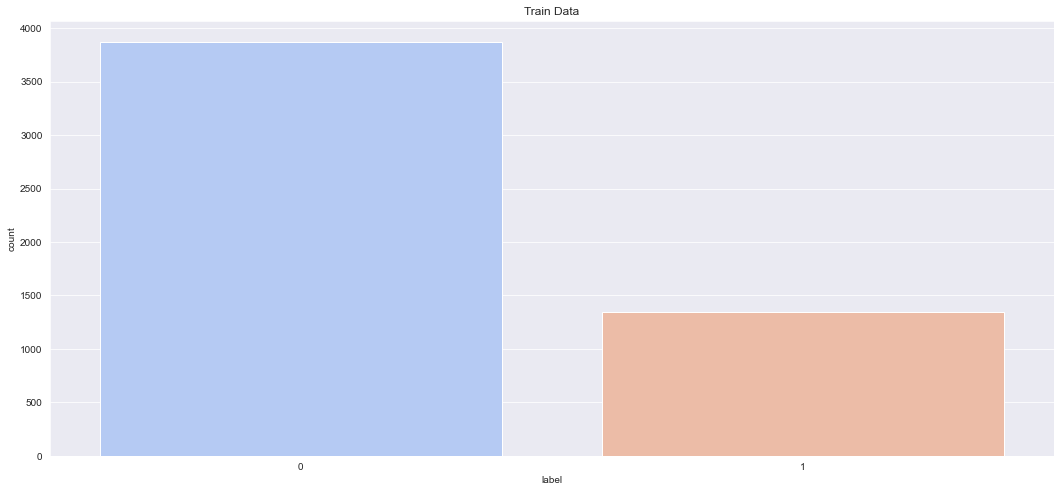

In [9]:
#visualizing data distribution in train set, first creating a dataframe to help plot
train_df = pd.DataFrame(train, columns=['image', 'label'])

plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train Data')

plt.show()

The training data appears imbalanced, with many more instances of pneumonia compared to normal. Data augmentation will help balance the distribution, this will be done in the data preparation section below.

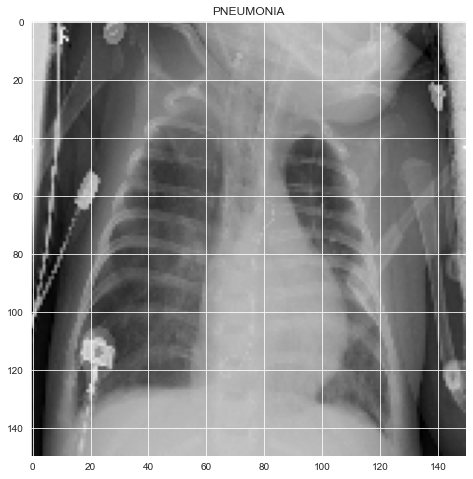

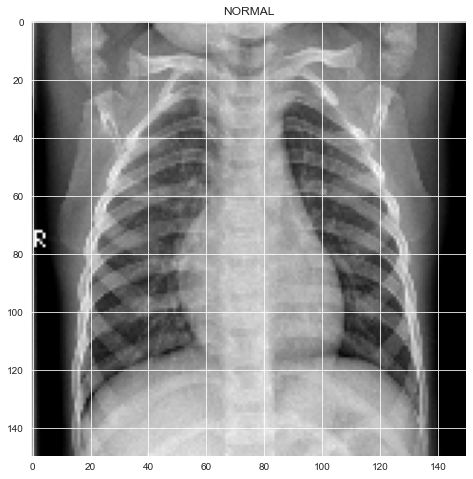

In [16]:
#sample image to see what the x-rays look like to begin with
plt.figure(figsize= (8, 8))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]]);

plt.figure(figsize= (8, 8))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]]);

## Data Preparation

The 3 datasets are split into train, test splits. Following this, image normalization and reshaping is done so that the images can be more easily interpreted once trained on a model. As previously mentioned, data augmentation is implemented.

In [18]:
#splitting data into X_train, y_train, etc.
X_train = []
y_train = []

X_test = []
y_test = []

X_val = []
y_val = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

In [19]:
#since these images are x-rays, they are a little more complex than simple images which is better suited for MLP
#cnn is probably better suited after a baseline model
#cnn takes 4-D tensors as input, which is what we have
#first, must normalize image data (since all pixel values will always be between 0 and 255)
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

In [20]:
X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [21]:
#checking the shape of X_train array
X_train.shape

(5216, 150, 150, 1)

In [22]:
#data augmentation, applies random transformations on each image as it is passed to the model
#makes model more robust and saves on memory
#also prevents overfitting and handling imbalance in dataset
#instatiate ImageDataGenerator for data augmentation and then pass through each path to the 3 datasets

datagen = ImageDataGenerator()

train_it = datagen.flow_from_directory(train_path, class_mode='binary', batch_size=32)
test_it = datagen.flow_from_directory(test_path, class_mode='binary', batch_size=32)
val_it = datagen.flow_from_directory(val_path, class_mode='binary', batch_size=32)

Found 5216 images belonging to 2 classes.
Found 511 images belonging to 2 classes.
Found 129 images belonging to 2 classes.


In [ ]:
# train_datagen = ImageDataGenerator(rescale=1. / 255,
#                                    samplewise_center=True,
#                                    samplewise_std_normalization=True,
#                                    rotation_range=15,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True)
# test_datagen = ImageDataGenerator(rescale=1. / 255,
#                                   featurewise_center=True,
#                                   featurewise_std_normalization=True)

# train_generator = train_datagen.flow_from_directory(train_path,
#                                                     target_size=(150, 150),
#                                                     batch_size=32,
#                                                     class_mode='binary')
# test_generator = test_datagen.flow_from_directory(test_path,
#                                                   target_size=(150, 150),
#                                                   batch_size=32,
#                                                   class_mode='binary')
# val_generator = test_datagen.flow_from_directory(val_path,
#                                                  target_size=(150, 150),
#                                                  batch_size=32,
#                                                  class_mode='binary')

In [ ]:
# #displaying random images to see how they look after creating the generators
# print('Display Random Images')

# # Adjust the size of your images
# plt.figure(figsize=(20,10))

# for i in range(12):
#     num = rn.randint(1,30)
#     plt.subplot(3,4, i + 1)
    
#     x,y = train_generator.__getitem__(num)
    
#     plt.imshow(x[num],cmap='gray')
#     plt.axis('off')
    
# # Adjust subplot parameters to give specified padding
# plt.tight_layout()

In [ ]:
# #visualize examples from the train dataset #need to add label
# plt.figure(figsize=(5, 5))
# plt.imshow(train[0][0])

In [ ]:
# plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
# plt.show()

In [ ]:
# #checking the shape/format of our input
# X_train

In [ ]:
# #since this is currently a list, change to arrays
# X_train = np.array(X_train)
# y_train = np.array(y_train)

# X_test = np.array(X_test)
# y_train = np.array(y_train)

# X_val = np.array(X_val)
# y_val = np.array(y_val)

In [ ]:
# print('Train Shape:', X_train.shape)
# print('Test Shape:', X_test.shape)

In [ ]:
# datagen = ImageDataGenerator(featurewise_center=False,
#                              featurewise_std_normalization=False,
#                              rotation_range=20,
#                              width_shift_range=0.2,
#                              height_shift_range=0.2,
#                              horizontal_flip=True)
# datagen.fit(X_train)

## Modeling

### Baseline Model

In [27]:
#baseline model (helpful code from Joél study group)
def baseline_model(image):
    layers = [
        Input(image.shape),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(1, activation='sigmoid'),
    ]
    model = Sequential(layers)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', #gradient descent, moving average
                  metrics=['accuracy'])
    return model

In [28]:
#initialize the model and pass in 1 of the train images to set the shape of input images
model_1 = baseline_model(X_train[0])

In [29]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 22500)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2250100   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,250,201
Trainable params: 2,250,201
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_1.fit(X_train, y_train, validation_split=.2, epochs=10, batch_size=1000)

Epoch 1/10
5/5 [==============================] - 3s 188ms/step - loss: 2.9709 - accuracy: 0.9288 - val_loss: 24.8238 - val_accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 0s 68ms/step - loss: 1.6196 - accuracy: 0.7198 - val_loss: 20.2652 - val_accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 0s 65ms/step - loss: 1.7997 - accuracy: 0.9288 - val_loss: 28.1098 - val_accuracy: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 0s 62ms/step - loss: 1.7077 - accuracy: 0.9288 - val_loss: 10.3754 - val_accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 0s 62ms/step - loss: 0.5691 - accuracy: 0.8327 - val_loss: 3.1708 - val_accuracy: 0.0335
Epoch 6/10
5/5 [==============================] - 0s 64ms/step - loss: 0.4840 - accuracy: 0.9291 - val_loss: 7.5446 - val_accuracy: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 0s 62ms/step - loss: 0.3378 - accuracy: 0.9295 - val_loss: 0.3573 - val_accuracy: 0.8534
Ep

In [50]:
# model_1 = Sequential()
# model_1.add(Dense(64, activation='relu', input_shape=(150, 150, 1)))
# model_1.add(Dense(10, activation='sigmoid'))

In [51]:
# model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# model_1.fit_generator(train_it, steps_per_epoch=16, validation_data=val_it, validation_steps=8)

In [ ]:
# model_1.summary()

In [ ]:
# model_1.fit(train_generator, validation_data=test_generator)

In [ ]:
# #fit the model
# base = model_1.fit(datagen.flow(X_train, y_train, batch_size=32),
#                    epochs=10,
#                    validation_)

### Basic Convolutional Neural Network (CNN) Model

In [16]:
def conv_1(image):
    layers = [
        Input(image.shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid'),
    ]
    model = Sequential(layers)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [17]:
model_2 = conv_1(X_train[0])

In [18]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               22429824  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 22,430,273
Trainable params: 22,430,273
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_2.fit(X_train, y_train, validation_split=.2, epochs=10, batch_size=1000)

Epoch 1/10
5/5 [==============================] - 28s 4s/step - loss: 2.6927 - accuracy: 0.7236 - val_loss: 41.7520 - val_accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 20s 4s/step - loss: 2.3901 - accuracy: 0.9288 - val_loss: 13.3006 - val_accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 18s 3s/step - loss: 0.8384 - accuracy: 0.7299 - val_loss: 3.8482 - val_accuracy: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 17s 3s/step - loss: 0.5143 - accuracy: 0.9288 - val_loss: 10.6510 - val_accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 16s 3s/step - loss: 0.6880 - accuracy: 0.9288 - val_loss: 5.9926 - val_accuracy: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 19s 4s/step - loss: 0.2804 - accuracy: 0.9358 - val_loss: 0.9060 - val_accuracy: 0.4349
Epoch 7/10
5/5 [==============================] - 18s 4s/step - loss: 0.1658 - accuracy: 0.9338 - val_loss: 1.7061 - val_accuracy: 0.1006
Epoch 8/10


### Deeper CNN Model

### Transfer Learning